
### Modelo Autoregressivo - AR(p)

Nos modelos de média móvel como o Holt-Winters, prevemos a variável de interesse utilizando uma combinação linear de preditores. Em nosso exemplo, previmos a quantidade de passageiros de companhias aéreas com base em um conjunto de preditores de nível, tendência e sazonalidade.

Em um modelo de autorregressão, fazemos previsões usando uma combinação linear de valores passados ​​da variável. O termo autorregressão descreve uma regressão da variável contra si mesma. Uma autorregressão é executada em um conjunto de valores defasados ​​de ordem $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

onde $c$ é uma constante, $\phi_{1}$ e $\phi_{2}$ são coeficientes de defasagem até a ordem $p$, e $\varepsilon_{t}$ é ruído branco.

Por exemplo, um modelo AR(1) terá a seguinte fórmula:

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

Já para um modelo AR(2) a fórmula será:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

e assim por diante.

Note que os coeficiente de defasagem são normalmente menores que 1, tendo em vista que os modelos autoregressivos são limitados a dados estacionários.

Assim, para um modelo <strong>AR(1)</strong>: $-1 \lt \phi_1 \lt 1$<br>
e para um modelo <strong>AR(2)</strong>: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Modelos <strong>AR(3)</strong> são matematicamente muito complexos. Felizmente statsmodels realiza esse processamento matemáico para nós.

### Fazendo os imports e carregando os datasets
Para este exercício, analisaremos as estimativas mensais da população dos EUA em milhares, de janeiro de 2011 a dezembro de 2018 (96 registros, 8 anos de dados).  A estimativa mensal é a média das estimativas do primeiro dia do mês e do primeiro dia do mês seguinte.

Fonte: https://fred.stlouisfed.org/series/POPTHM

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools


from statsmodels.tsa.ar_model import AutoReg

# Load the U.S. Population dataset
df = pd.read_csv('uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [7]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


### Plotando os dados

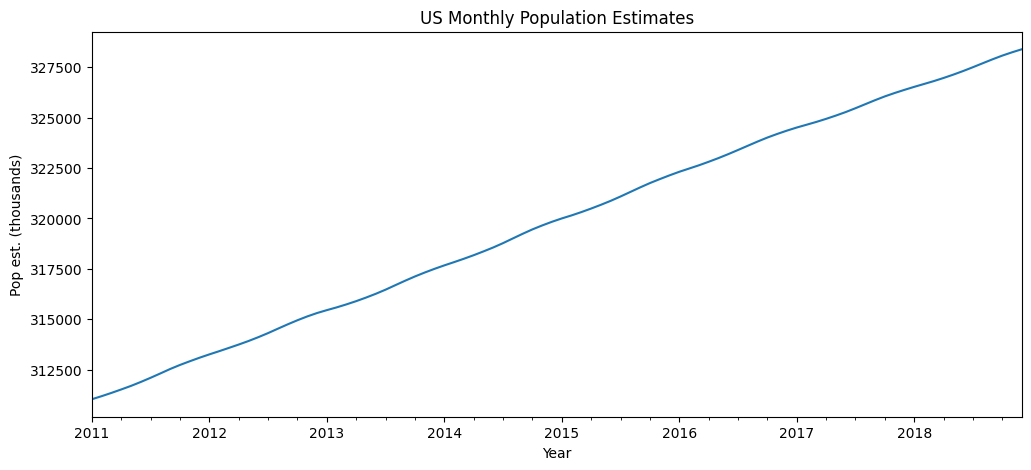

In [5]:
title = 'US Monthly Population Estimates'
yl = "Pop est. (thousands)"
xl= 'Year'
ax = df['PopEst'].plot(figsize=(12,5) , title=title,ylabel=yl, xlabel=xl)
ax.autoscale(axis='x' , tight=True)

### Dividindo os dados em conjuntos de treino/teste

O objetivo nesta seção é:
* Dividir os dados conhecidos em um conjunto de registros de treinamento para ajustar o modelo
* Usar os registros restantes para teste, a fim de avaliar o modelo
* Ajustar o modelo novamente no conjunto <em>completo</em> de registros
* Obter um conjunto futuro de valores (previsão) usando o modelo

Como regra geral, deve-se definir a duração do conjunto de testes igual ao tamanho da previsão pretendida. Ou seja, para um conjunto de dados mensal, pode ser interessante prever mais um ano. Portanto, o conjunto de testes deve durar um ano.

In [7]:
len(df)         


96

In [8]:
treino = df.iloc[:84]
teste = df.iloc[84:]

### Ajustando um modelo AR(1)

In [9]:
# Ignorando warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
model = AutoReg(treino['PopEst'], lags=1)
AR1fit = model.fit()
print(f'Coeficientes:\n{AR1fit.params}')

Coeficientes:
const        284.913797
PopEst.L1      0.999686
dtype: float64


In [13]:
start = len(treino)
end = len(treino) + len(teste) - 1
prev1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('Previsões AR1')

In [14]:
prev1

2018-01-01    326560.403377
2018-02-01    326742.749463
2018-03-01    326925.038278
2018-04-01    327107.269838
2018-05-01    327289.444162
2018-06-01    327471.561268
2018-07-01    327653.621173
2018-08-01    327835.623896
2018-09-01    328017.569455
2018-10-01    328199.457868
2018-11-01    328381.289152
2018-12-01    328563.063326
Freq: MS, Name: Previsões AR1, dtype: float64

<Axes: xlabel='DATE'>

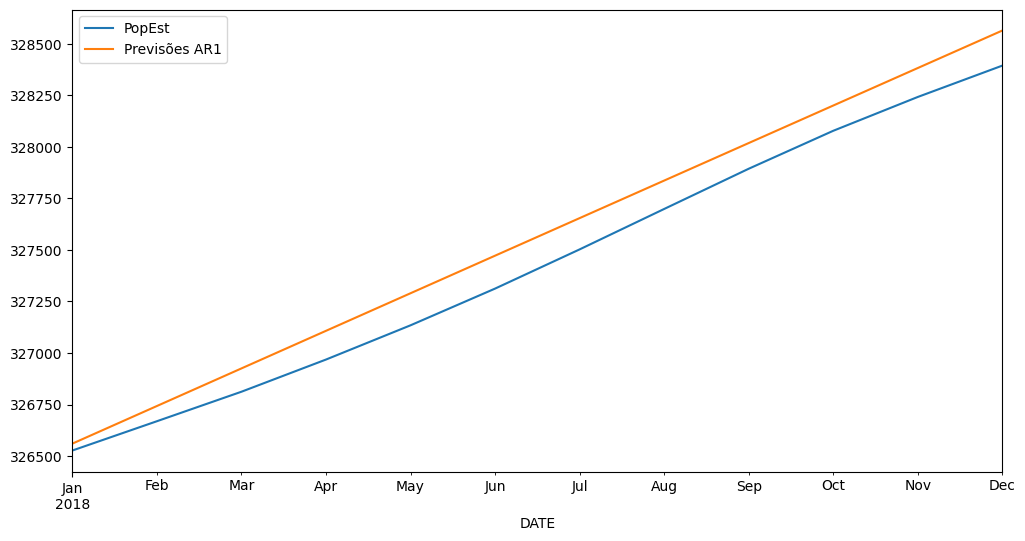

In [15]:
teste['PopEst'].plot(legend=True)
prev1.plot(legend=True, figsize=(12,6))

### Ajustando um modelo AR(2)

In [22]:
model = AutoReg(treino['PopEst'], lags=8)
AR2fit = model.fit()
print(f'Coeficientes:\n{AR2fit.params}')

Coeficientes:
const        82.309677
PopEst.L1     2.437997
PopEst.L2    -2.302100
PopEst.L3     1.565427
PopEst.L4    -1.431211
PopEst.L5     1.125022
PopEst.L6    -0.919494
PopEst.L7     0.963694
PopEst.L8    -0.439511
dtype: float64


In [23]:
start = len(treino)
end = len(treino) + len(teste) - 1
prev1 = AR2fit.predict(start=start, end=end, dynamic=False).rename('Previsões AR2')

<Axes: xlabel='DATE'>

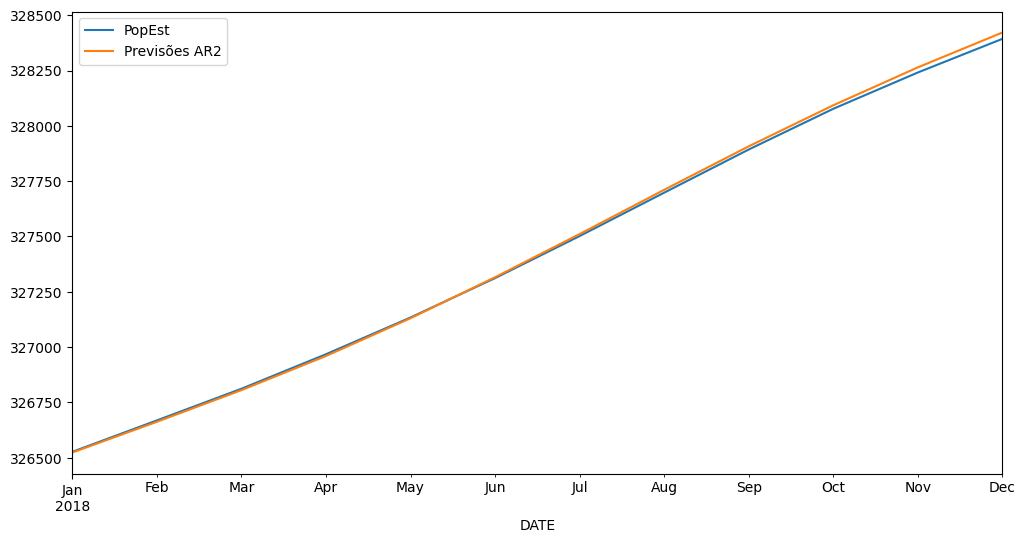

In [24]:
teste['PopEst'].plot(legend=True)
prev1.plot(legend=True, figsize=(12,6))

### Descobrindo o melhor p para AR(p)
Vamos plotar um gráfico de autocorrelação parcial PACF para descobrir o melhor p (lag)

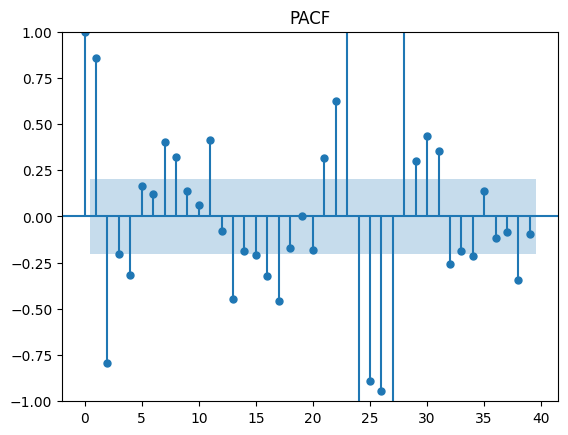

In [27]:
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_pacf
df['diff1'] = diff(df['PopEst'], k_diff=1)

title="PACF"
lags=40
plot_pacf(df['diff1'].dropna() , title=title, lags=np.arange(40));


Temos que p = 8, portando usaremos lags=8.

In [28]:
model = AutoReg(treino['PopEst'], lags=8)
ARpfit = model.fit()
print(f'Coeficientes:\n{ARpfit.params}')

Coeficientes:
const        82.309677
PopEst.L1     2.437997
PopEst.L2    -2.302100
PopEst.L3     1.565427
PopEst.L4    -1.431211
PopEst.L5     1.125022
PopEst.L6    -0.919494
PopEst.L7     0.963694
PopEst.L8    -0.439511
dtype: float64


In [29]:
start = len(treino)
end = len(treino) + len(teste) - 1
prevp = AR2fit.predict(start=start, end=end, dynamic=False).rename('Previsões AR8')

teste['PopEst'].plot(legend=True)
prevp.plot(legend=True, figsize=(12,6))

### Avaliando o modelo
É importante comparar a eficiência dos modelos. Vamos utilizar o mean_squared_error para fazer essa comparação.

In [10]:
from sklearn.metrics import mean_squared_error



Vemos que AR(8) tem um resultado bem melhor que os outros dois modelos.

Outro método é o <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), que avalia melhor os modelos, evitando overfitting.
Felizmente, este método está disponível diretamente no objeto de ajuste do modelo.

In [ ]:
modelos = [AR]

## Previsão
Agora estamos prontos para treinar nosso melhor modelo com a maior quantidade de dados e ajustá-lo a datas futuras.